In [1]:
%pylab inline

%load_ext autoreload
%autoreload 2

import sys
#import seaborn as sns
from multiprocessing import Queue, Event, Process

sys.path.insert(0, '/home/chwala-c/code/pySNMPdaq/')
from pySNMPdaq import SnmpDAQSession

Populating the interactive namespace from numpy and matplotlib


In [139]:
from matplotlib import rcParams

rcParams.update({'font.size':14,
                 'lines.linewidth': 2})

# Plot results of manual tests 

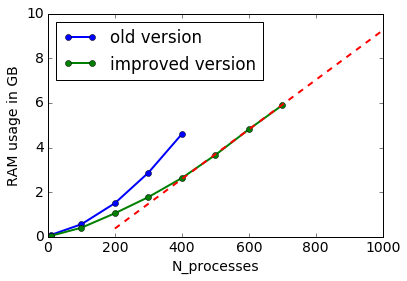

In [4]:
N = [0, 10, 100, 200, 300, 400, 500, 600, 700]
old_mem = array([2607, 2697, 3170, 4114, 5479, 7211, nan, nan, nan])/1e3
new_mem = array([2362, 2455, 2869, 3567, 4579, 5920, nan, nan, nan])/1e3
nv2_mem = array([1929, 1978, 2336, 2983, 3708, 4562, 5596, 6742, 7827])/1e3

plot(N, array(old_mem)-old_mem[0], '-o', label='old version')
#plot(N, array(new_mem)-new_mem[0], '-o')
plot(N, array(nv2_mem)-nv2_mem[0], '-o', label='improved version')
plot(arange(200,1000), (arange(200,1000)*11.1-1850)/1e3, '--')

legend(loc=2)
xlabel('N_processes')
ylabel('RAM usage in GB')
savefig('/home/chwala-c/Dropbox//misc/pySNMPdaq_RAM_usage_improved.png', dpi=300)

# Plot memory consumptions for different interprocess communications 

Data is produced by `test_run_fixed_N.py` which is called by `call_test_run_fixed_N.sh`. The bash-script is used to avioid accumulating memory consumption which happens in a python script that iterates over different `N`s and initializes and kill the corresponding processes. Python seem not to clean up completely as long as the inital "partent" process, here the script, runs.

 * Implementation #0 uses the current snmpDAQSession implementation which uses an `Event()` per Session to trigger the request
 * Implementation #1 uses a dummy class and a `Queue()` for triggering each `Process()`.
 * Implementation #2 uses a dummy class and an `Event()` for triggering each `Process()`.
 * Implementation #3 uses a dummy class and has no interprocess communication, no `Queue()`, no `Event()`.
 * Implementation #4 similar to #2 but the worker is now a Class method
 * Implementation #5 uses a dummy class and only one `Queue()` for triggering all `Process()`es.
   * Question: How fast is putting and getting 1000 objects to one `Queue()` compared to setting 1000 `Events()`? See test below

In [5]:
import pandas as pd

In [132]:
%matplotlib inline

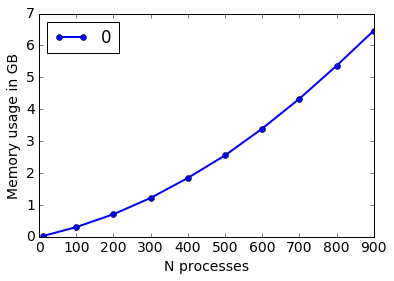

In [143]:
df = pd.read_csv('/home/chwala-c/code/pySNMPdaq/mem_test_results.csv',
                 names=['implementation', 'N', 'mem_before', 'mem_during', 'mem_after'])

grouped = df.groupby(['implementation'])

for name, group in grouped:
    plot(group.N, group.mem_during-group.mem_before, '-o', label=name)
    legend(loc=2)
#plot(arange(200,1000), (arange(200,1000)*11.1-1850)/1e3, '--')
xlabel('N processes')
ylabel('Memory usage in GB');


# Plot mem usage for current implementation for paper 

[ -7.18080354e-03   2.56066755e-03   5.17251935e-06]
[  5.17251937e-06   2.56066752e-03  -7.18079732e-03]


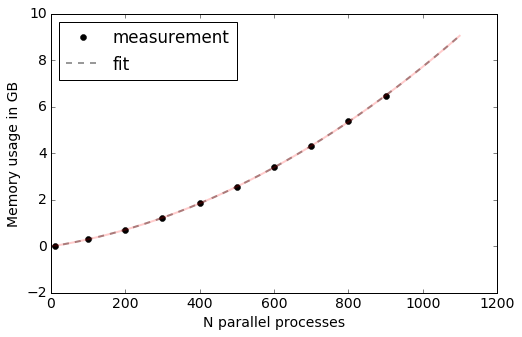

In [184]:
from scipy.optimize import curve_fit
def f(N_proc, a, b, c):
    mem_GB = a+b*N_proc+c*N_proc**2
    return mem_GB

fig, ax = subplots(figsize=(8,5))
for name, group in grouped:
    if name == 0:
        ax.plot(group.N.values, 
                group.mem_during.values-group.mem_before.values, 
                'ko', label='measurement')
        popt, pcov = curve_fit(f, 
                               group.N.values, 
                               group.mem_during.values-group.mem_before.values,
                               p0=(0.01, 0.01, 0.01))
        p = polyfit(group.N.values,
                               group.mem_during.values-group.mem_before.values,
                               deg=2)
        
xlabel('N parallel processes')
ylabel('Memory usage in GB')

Nvec=arange(1,1100)
#ax.plot(Nvec, f(Nvec,  *popt), 'k--', alpha=0.4, label='$y=0.025\,x+0.023\,x^2$')
ax.plot(Nvec, f(Nvec,  *popt), 'k--', alpha=0.4, label='fit')
ax.plot(Nvec, poly1d(p)(Nvec), 'r', alpha=0.2)
ax.legend(loc=2, numpoints=1)
print popt
print p
savefig('../../Dropbox/misc/mem_usage_pySNMPdaq.png', dpi=300)

In [172]:
print f(2000, *popt)
print poly1d(p)(2000)

25.8580874863
25.8042317161


# Test performance of putting and getting 1000 objects to a `Queue()`

In [26]:
str(datetime.utcnow())

'2016-02-05 13:28:18.748514'

In [137]:
import os
import sys
from time import sleep
from datetime import datetime

class SnmpSessionDummy():
    def __init__(self,i):
        self.foo = 'bar'
        self.id = i
    def query(self):
        print '%s: [PID %s] fake query...' % (datetime.utcnow(), os.getpid())
        sys.stdout.flush()
        sleep(0.1)
        output_queue.put((self.id, datetime.utcnow()))

def worker(input_queue):
    while True:
        message = input_queue.get()
        if message == 'STOP':
            break
        if not isinstance(message, SnmpSessionDummy):
            raise ValueError('message must be either STOP or a SnmpSessionDummy')
        else:
            snmp_session = message
        print '%s: PID %s is doing a query' % (datetime.utcnow(), os.getpid())
        sys.stdout.flush()
        snmp_session.query()
        print '%s: PID %s is done' % (datetime.utcnow(), os.getpid())
        sys.stdout.flush()
        input_queue.task_done()
    print '%s: PID %s has finished' % (datetime.utcnow(), os.getpid())
    input_queue.task_done()
    
class SnmpSessionDummy_EventTrigger():
    def __init__(self, i):
        self.foo = 'bar'
        self.id = i
    def query(self):
        print '%s: [PID %s] fake query...' % (datetime.utcnow(), os.getpid())
        sys.stdout.flush()
        sleep(0.1)
        output_queue.put((self.id, datetime.utcnow()))
    def worker(self, trigger_event, queue_out):
        from os import getpid
        pid = getpid()
        snmp_session = 'some session'
        trigger_event.wait()
        query()
        while True:
            sleep(0.1)   

In [122]:
from multiprocessing import JoinableQueue

N = 500

input_queue = JoinableQueue()
output_queue = Queue()

snmp_sessions = []
jobs = []    

print 'Init session and processes'    

for i in range(N):
    snmp_sessions.append(SnmpSessionDummy(i))
    p = Process(target=worker, args=(input_queue,))
    p.start()
    jobs.append(p)
    
print 'put sessions to queue'
   
query_times_list = []
for n_query in range(5):
    for snmp_session in snmp_sessions:
        input_queue.put(snmp_session)
    sleep(1)
    results = []
    while not output_queue.empty():
        results.append(output_queue.get()[1])
    query_times_list.append((n_query, results))
    
    
print 'terminate processes'

for p in jobs:
    input_queue.put('STOP')

for p in jobs:
    p.join()
    print '%s was joined' % str(p)
    p.terminate()
    
input_queue.join()

Init session and processes
put sessions to queue
terminate processes2016-02-05 15:06:36.405593: PID 31148 is doing a query
2016-02-05 15:06:36.404674: PID 31160 is doing a query
2016-02-05 15:06:36.408180: PID 31161 is doing a query
2016-02-05 15:06:36.408603: PID 31129 is doing a query
2016-02-05 15:06:36.405513: PID 31165 is doing a query
2016-02-05 15:06:36.409469: PID 31157 is doing a query
2016-02-05 15:06:36.408048: PID 31159 is doing a query
2016-02-05 15:06:36.408843: PID 31132 is doing a query
2016-02-05 15:06:36.406293: PID 31164 is doing a query
2016-02-05 15:06:36.412940: PID 31155 is doing a query
2016-02-05 15:06:36.408507: PID 31147 is doing a query
2016-02-05 15:06:36.414027: PID 31135 is doing a query
2016-02-05 15:06:36.413040: PID 31127 is doing a query
2016-02-05 15:06:36.404836: PID 31139 is doing a query
2016-02-05 15:06:36.415473: PID 31141 is doing a query
2016-02-05 15:06:36.415893: PID 31133 is doing a query
2016-02-05 15:06:36.408406: PID 31153 is doing a que

In [61]:
%matplotlib notebook

<IPython.core.display.Javascript object>


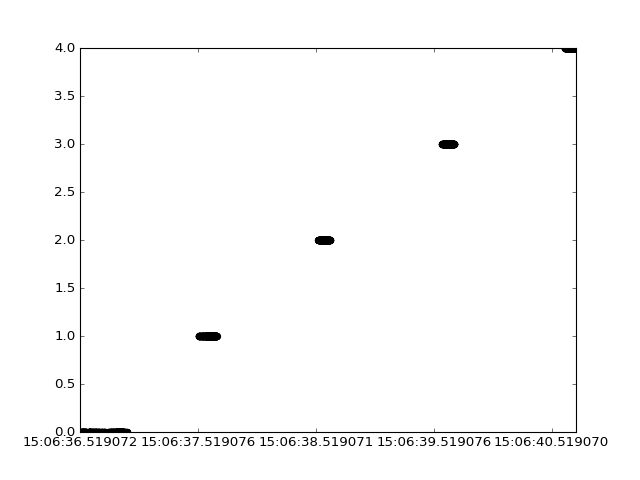

In [125]:
fig,ax = subplots()
for query_times in query_times_list:
    ax.plot(query_times[1],ones(len(query_times[1]))*query_times[0], 'ko')

<IPython.core.display.Javascript object>


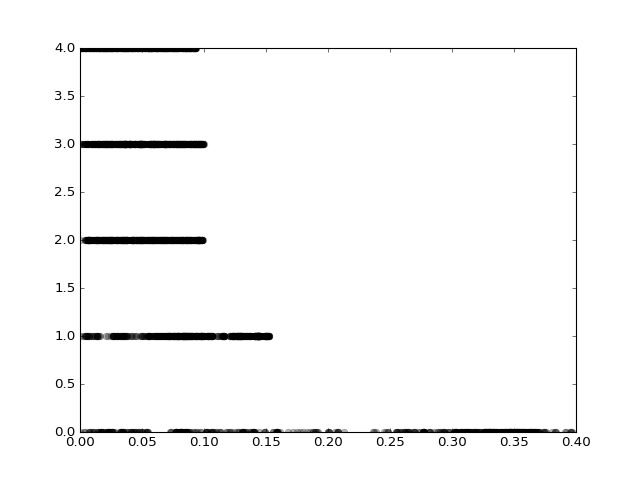

In [124]:
fig, ax = subplots()
for query_times in query_times_list:
    t_min = array(query_times[1]).min()
    t_offsets = array([(t-t_min).microseconds for t in query_times[1]])/1e6
    ax.plot(t_offsets, ones_like(t_offsets)*query_times[0], 'ko', alpha=0.3)